# MedNeXt Inference
This notebook runs MedNeXt inference on multi-modal MRI data, exports a submission CSV, and includes optional visualization and verification steps.

In [1]:
!git clone https://github.com/MIC-DKFZ/MedNeXt.git mednext
!pip install -e ./mednext

Cloning into 'mednext'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 762 (delta 270), reused 244 (delta 244), pack-reused 442 (from 1)
Receiving objects: 100% (762/762), 522.43 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (459/459), done.
Obtaining file:///kaggle/working/mednext
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.5 MB/s eta 0:00:00
  Created wheel for batchgenerators: filename=batchgenerators-0.25.1-py3-none-an

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import nibabel as nib
from tqdm import tqdm
from typing import List, Tuple, Dict
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

repo_path = os.path.abspath('mednext')
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

try:
    from nnunet_mednext import create_mednext_v1, MedNeXt
    print("MedNeXt library imported successfully.")
except ImportError as e:
    print(f"Error importing MedNeXt: {e}")

MODEL_PATH = "/kaggle/input/mednext/pytorch/default/1/best_model.pt"
DATASET_PATH = "/kaggle/input/instant-odc-ai-hackathon/test"
NUM_SAMPLES_TO_VISUALIZE = 5

class InferenceConfig:
    MODEL_SIZE = 'B'
    KERNEL_SIZE = 3
    IN_CHANNELS = 4
    NUM_CLASSES = 4
    PATCH_SIZE = (128, 128, 128)
    USE_AMP = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_mednext_model(checkpoint_path, config):
    print("Initializing model architecture...")
    model = create_mednext_v1(
        num_input_channels=config.IN_CHANNELS,
        num_classes=config.NUM_CLASSES,
        model_id=config.MODEL_SIZE,
        kernel_size=config.KERNEL_SIZE,
        deep_supervision=False
    )

    model.to(config.DEVICE)

    if os.path.exists(checkpoint_path):
        print(f"Loading weights from {checkpoint_path}...")
        try:
            checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)

            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint

            model.load_state_dict(state_dict, strict=False)
            model.eval()
            print("Model loaded successfully (ignored auxiliary training heads).")

            if isinstance(checkpoint, dict) and 'metrics' in checkpoint:
                print(f"Best validation Dice: {checkpoint['metrics'].get('Mean', 0):.4f}")
        except Exception as e:
            print(f"Error loading weights: {e}")
    else:
        print(f"Checkpoint file not found at {checkpoint_path}")

    return model

model = load_mednext_model(MODEL_PATH, InferenceConfig)

✅ MedNeXt library imported successfully!
Initializing model architecture...
Loading weights from /kaggle/input/mednext/pytorch/default/1/best_model.pt...
✅ Model loaded successfully (ignored auxiliary training heads)!
   (Best Validation Dice: 0.8268)


In [ ]:
def load_model_for_inference(model_path, config):
    """
    Load the trained MedNeXt model for inference.

    Args:
        model_path: Path to the saved model checkpoint
        config: InferenceConfig object with model settings

    Returns:
        Loaded model in evaluation mode
    """
    checkpoint = torch.load(model_path, map_location=config.DEVICE, weights_only=False)

    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    elif isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    elif isinstance(checkpoint, dict):
        state_dict = checkpoint
    else:
        state_dict = checkpoint

    has_deep_supervision = any('out_1' in key or 'out_2' in key or 'out_3' in key or 'out_4' in key for key in state_dict.keys())
    print(f"Checkpoint trained with deep supervision: {has_deep_supervision}")

    model = create_mednext_v1(
        num_input_channels=config.IN_CHANNELS,
        num_classes=config.NUM_CLASSES,
        model_id=config.MODEL_SIZE,
        kernel_size=config.KERNEL_SIZE,
        deep_supervision=has_deep_supervision
    )

    model.load_state_dict(state_dict)

    if isinstance(checkpoint, dict):
        if 'epoch' in checkpoint:
            print(f"Loaded model from epoch {checkpoint.get('epoch', 'N/A')}")
        if 'best_val_dice' in checkpoint:
            print(f"Best validation Dice: {checkpoint.get('best_val_dice'):.4f}")
        if 'metrics' in checkpoint:
            print(f"Checkpoint metrics: {checkpoint['metrics']}")

    model = model.to(config.DEVICE)
    model.eval()

    print(f"Model loaded successfully from: {model_path}")
    return model

inference_model = load_model_for_inference(MODEL_PATH, InferenceConfig)
print(f"\nModel is on device: {next(inference_model.parameters()).device}")

Checkpoint trained with deep supervision: True
Loaded model from epoch 17
Checkpoint metrics: {'loss': 0.23175636894140111, 'NCR/NET': np.float64(0.7710893505270986), 'Edema': np.float64(0.847211789324939), 'ET': np.float64(0.8582444400276128), 'Mean': np.float64(0.8268432145415567), 'WT': np.float64(0.9231405391754857), 'TC': np.float64(0.8996114450280992)}
Model loaded successfully from: /kaggle/input/mednext/pytorch/default/1/best_model.pt

Model is on device: cuda:0


In [ ]:
class InferenceDataset(Dataset):
    """
    Dataset for inference that loads full volumes without patch extraction.
    Auto-detects common modality naming patterns.
    """

    def __init__(self, data_dir: str, subject_ids: List[str] = None):
        self.data_dir = data_dir

        self.modality_patterns = [
            ['t1', 't1ce', 't2', 'flair'],
            ['T1', 'T1ce', 'T2', 'FLAIR'],
            ['T1', 'T1CE', 'T2', 'FLAIR'],
            ['t1', 't1Gd', 't2', 'flair'],
        ]

        if subject_ids is None:
            if os.path.exists(data_dir):
                all_items = os.listdir(data_dir)
                self.subject_ids = sorted([
                    d for d in all_items
                    if os.path.isdir(os.path.join(data_dir, d))
                ])
            else:
                self.subject_ids = []
        else:
            self.subject_ids = subject_ids

        print(f"Found {len(self.subject_ids)} subjects in dataset")
        if len(self.subject_ids) > 0:
            print(f"Sample subjects: {self.subject_ids[:3]}")

        self.modalities = self._detect_modality_pattern()
        print(f"Detected modalities: {self.modalities}")

    def _detect_modality_pattern(self):
        """Auto-detect the modality file naming pattern."""
        if len(self.subject_ids) == 0:
            return ['t1', 't1ce', 't2', 'flair']

        subject_id = self.subject_ids[0]
        subject_dir = os.path.join(self.data_dir, subject_id)

        if not os.path.exists(subject_dir):
            return ['t1', 't1ce', 't2', 'flair']

        files = os.listdir(subject_dir)

        for pattern in self.modality_patterns:
            found_all = True
            for mod in pattern:
                possible_names = [
                    f"{subject_id}_{mod}.nii.gz",
                    f"{subject_id}-{mod}.nii.gz",
                    f"{subject_id}_{mod}.nii",
                    f"{mod}.nii.gz",
                    f"{mod}.nii",
                ]
                if not any(name in files for name in possible_names):
                    found_all = False
                    break

            if found_all:
                return pattern

        detected = []
        modality_keywords = {
            't1ce': ['t1ce', 't1gd', 't1Gd', 'T1CE', 'T1Gd', 'T1ce'],
            't1': ['t1', 'T1'],
            't2': ['t2', 'T2'],
            'flair': ['flair', 'FLAIR', 'Flair'],
        }

        for mod_key, keywords in modality_keywords.items():
            for f in files:
                f_lower = f.lower()
                if any(kw.lower() in f_lower for kw in keywords):
                    for kw in keywords:
                        if kw in f:
                            detected.append(kw)
                            break
                    break

        if len(detected) == 4:
            return detected

        return ['t1', 't1ce', 't2', 'flair']

    def __len__(self):
        return len(self.subject_ids)

    def _find_modality_file(self, subject_dir: str, subject_id: str, modality: str) -> str:
        """Find the file for a given modality, trying different naming conventions."""
        files = os.listdir(subject_dir)

        patterns = [
            f"{subject_id}_{modality}.nii.gz",
            f"{subject_id}-{modality}.nii.gz",
            f"{subject_id}_{modality}.nii",
            f"{modality}.nii.gz",
            f"{modality}.nii",
        ]

        for pattern in patterns:
            if pattern in files:
                return os.path.join(subject_dir, pattern)

        modality_lower = modality.lower()
        for f in files:
            if modality_lower in f.lower() and ('nii' in f.lower()):
                if modality_lower == 't1':
                    if 't1ce' not in f.lower() and 't1gd' not in f.lower():
                        return os.path.join(subject_dir, f)
                else:
                    return os.path.join(subject_dir, f)

        raise FileNotFoundError(f"Could not find {modality} file in {subject_dir}. Available files: {files}")

    def _load_nifti(self, filepath: str) -> np.ndarray:
        """Load a NIfTI file and return the data array."""
        img = nib.load(filepath)
        return img.get_fdata().astype(np.float32)

    def _normalize(self, data: np.ndarray) -> np.ndarray:
        """Robust Z-score normalization with percentile clipping."""
        mask = data > 0
        if mask.sum() == 0:
            return data

        pixels = data[mask]
        p_low, p_high = np.percentile(pixels, 0.5), np.percentile(pixels, 99.5)
        data = np.clip(data, p_low, p_high)

        pixels = data[mask]
        mean, std = pixels.mean(), pixels.std()

        data = (data - mean) / (std + 1e-8)
        data[~mask] = 0
        return data

    def __getitem__(self, idx: int):
        subject_id = self.subject_ids[idx]
        subject_dir = os.path.join(self.data_dir, subject_id)

        modality_data = []
        for mod in self.modalities:
            filepath = self._find_modality_file(subject_dir, subject_id, mod)
            data = self._load_nifti(filepath)
            data = self._normalize(data)
            modality_data.append(data)

        volume = np.stack(modality_data, axis=0)

        seg = None
        seg_patterns = [
            f"{subject_id}_seg.nii.gz",
            f"{subject_id}-seg.nii.gz",
            f"seg.nii.gz",
            f"{subject_id}_mask.nii.gz",
        ]

        files = os.listdir(subject_dir)
        for pattern in seg_patterns:
            if pattern in files:
                seg_path = os.path.join(subject_dir, pattern)
                seg = self._load_nifti(seg_path)
                new_seg = np.zeros_like(seg)
                new_seg[seg == 0] = 0
                new_seg[seg == 1] = 1
                new_seg[seg == 2] = 2
                new_seg[seg == 4] = 3
                seg = new_seg
                break

        volume_tensor = torch.from_numpy(volume.copy()).float()

        return {
            'subject_id': subject_id,
            'volume': volume_tensor,
            'ground_truth': seg,
            'original_shape': volume.shape[1:]
        }

inference_dataset = InferenceDataset(DATASET_PATH)
print(f"\nInference dataset created with {len(inference_dataset)} subjects")

Found 334 subjects in dataset
Sample subjects: ['BraTS2021_01333', 'BraTS2021_01334', 'BraTS2021_01335']
Files in first subject folder: ['BraTS2021_01333_t2.nii', 'BraTS2021_01333_t1.nii', 'BraTS2021_01333_t1ce.nii', 'BraTS2021_01333_flair.nii']
Detected modalities: ['t1', 't1ce', 't2', 'flair']

Inference dataset created with 334 subjects


In [ ]:
def sliding_window_inference(model, volume, config, patch_size=(128, 128, 128), overlap=0.5):
    """
    Perform sliding window inference for large 3D volumes.

    Args:
        model: Trained model
        volume: Input volume tensor (C, D, H, W)
        config: InferenceConfig object
        patch_size: Size of patches for inference
        overlap: Overlap ratio between patches

    Returns:
        Predicted segmentation mask
    """
    model.eval()
    device = config.DEVICE

    C, D, H, W = volume.shape
    pd, ph, pw = patch_size

    stride_d = int(pd * (1 - overlap))
    stride_h = int(ph * (1 - overlap))
    stride_w = int(pw * (1 - overlap))

    pad_d = max(0, pd - D)
    pad_h = max(0, ph - H)
    pad_w = max(0, pw - W)

    if pad_d > 0 or pad_h > 0 or pad_w > 0:
        volume = F.pad(volume, (0, pad_w, 0, pad_h, 0, pad_d))
        D, H, W = volume.shape[1:]

    output = torch.zeros((config.NUM_CLASSES, D, H, W), device=device)
    count = torch.zeros((D, H, W), device=device)

    d_positions = list(range(0, max(1, D - pd + 1), stride_d))
    h_positions = list(range(0, max(1, H - ph + 1), stride_h))
    w_positions = list(range(0, max(1, W - pw + 1), stride_w))

    if D > pd and D - pd not in d_positions:
        d_positions.append(D - pd)
    if H > ph and H - ph not in h_positions:
        h_positions.append(H - ph)
    if W > pw and W - pw not in w_positions:
        w_positions.append(W - pw)

    with torch.no_grad():
        for d_start in d_positions:
            for h_start in h_positions:
                for w_start in w_positions:
                    patch = volume[:, d_start:d_start+pd, h_start:h_start+ph, w_start:w_start+pw]
                    patch = patch.unsqueeze(0).to(device)

                    with torch.cuda.amp.autocast(enabled=config.USE_AMP):
                        pred = model(patch)

                    if isinstance(pred, (list, tuple)):
                        pred = pred[0]

                    pred = F.softmax(pred, dim=1).squeeze(0)

                    output[:, d_start:d_start+pd, h_start:h_start+ph, w_start:w_start+pw] += pred
                    count[d_start:d_start+pd, h_start:h_start+ph, w_start:w_start+pw] += 1

    output = output / count.unsqueeze(0).clamp(min=1)

    original_d = D - pad_d if pad_d > 0 else D
    original_h = H - pad_h if pad_h > 0 else H
    original_w = W - pad_w if pad_w > 0 else W
    output = output[:, :original_d, :original_h, :original_w]

    prediction = torch.argmax(output, dim=0).cpu().numpy()
    return prediction

Sliding window inference function defined!


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

def rle_encode_c_order(mask):
    """Encodes a binary mask using C-order flattening."""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

label_map = {1: 1, 2: 2, 3: 4}
submission_rows = []

print(f"Starting inference on {len(inference_dataset)} samples...")

inference_model.eval()

for idx in tqdm(range(len(inference_dataset))):
    sample = inference_dataset[idx]
    subject_id = sample['subject_id']
    volume = sample['volume']

    prediction = sliding_window_inference(
        inference_model,
        volume,
        InferenceConfig,
        patch_size=InferenceConfig.PATCH_SIZE,
        overlap=0.5
    )

    for model_label, comp_label in label_map.items():
        binary_mask = (prediction == model_label).astype(np.uint8)

        if binary_mask.sum() > 0:
            rle_string = rle_encode_c_order(binary_mask)
        else:
            rle_string = ""

        submission_rows.append({
            "id": f"{subject_id}_{comp_label}",
            "rle": rle_string
        })

    if idx % 50 == 0:
        torch.cuda.empty_cache()

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

print(f"\nSubmission generated with {len(submission_df)} rows.")
print(submission_df.head())

Running inference on 334 samples...


  0%|          | 0/334 [00:00<?, ?it/s]/tmp/ipykernel_55/4204801297.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.USE_AMP):
100%|██████████| 334/334 [38:08<00:00,  6.85s/it]



3D Multi-View Visualization (First Sample):


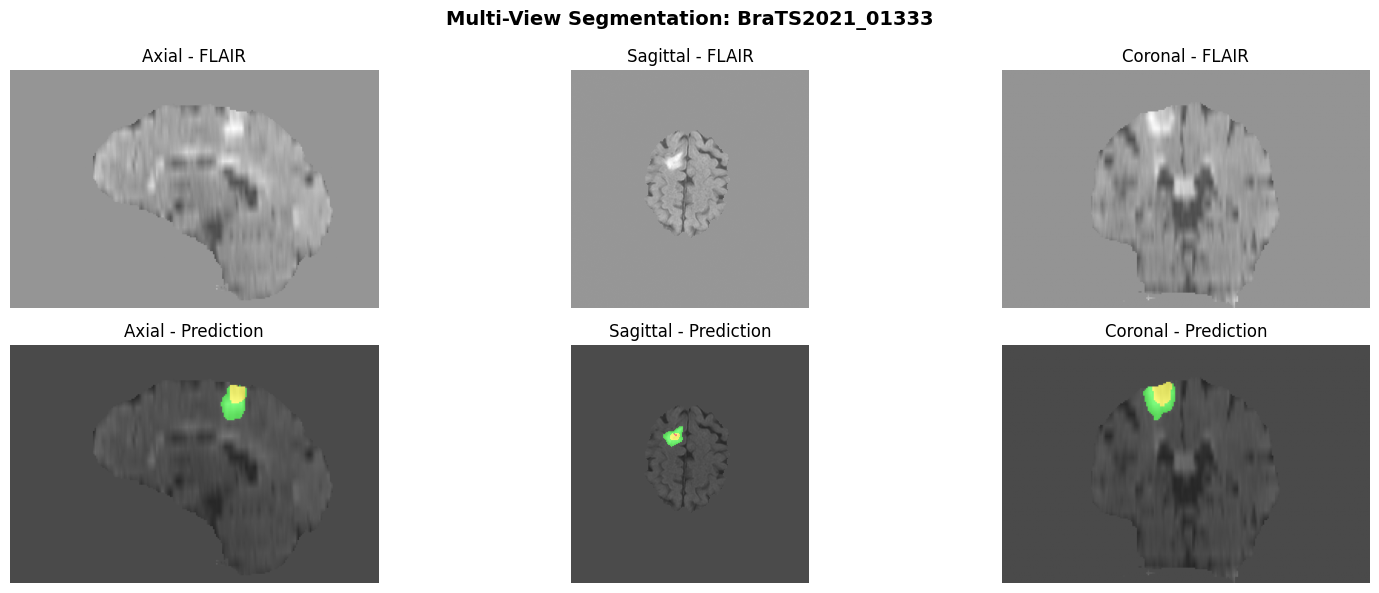

In [ ]:
def visualize_3d_segmentation(result, figsize=(16, 6)):
    """
    Create orthogonal views (axial, sagittal, coronal) for prediction and ground truth.

    Args:
        result: Dictionary containing prediction, ground truth, and volume
        figsize: Figure size
    """
    subject_id = result['subject_id']
    volume = result['volume']
    prediction = result['prediction']
    ground_truth = result['ground_truth']

    flair = volume[3]

    if ground_truth is not None:
        tumor_mask = ground_truth > 0
    else:
        tumor_mask = prediction > 0

    if tumor_mask.sum() > 0:
        coords = np.where(tumor_mask)
        center_d = int(np.mean(coords[0]))
        center_h = int(np.mean(coords[1]))
        center_w = int(np.mean(coords[2]))
    else:
        center_d, center_h, center_w = [s // 2 for s in flair.shape]

    colors = np.array([
        [0, 0, 0],
        [255, 0, 0],
        [0, 255, 0],
        [255, 255, 0]
    ]) / 255.0

    def apply_colormap(mask):
        colored = np.zeros((*mask.shape, 3))
        for i in range(4):
            colored[mask == i] = colors[i]
        return colored

    fig, axes = plt.subplots(2, 3, figsize=figsize)

    views = [
        ('Axial', flair[center_d], prediction[center_d], ground_truth[center_d] if ground_truth is not None else None),
        ('Sagittal', flair[:, :, center_w], prediction[:, :, center_w], ground_truth[:, :, center_w] if ground_truth is not None else None),
        ('Coronal', flair[:, center_h, :], prediction[:, center_h, :], ground_truth[:, center_h, :] if ground_truth is not None else None)
    ]

    for col, (view_name, img, pred, gt) in enumerate(views):
        axes[0, col].imshow(img.T, cmap='gray', origin='lower', alpha=0.7)
        if gt is not None:
            gt_colored = apply_colormap(gt)
            axes[0, col].imshow(gt_colored.transpose(1, 0, 2), origin='lower', alpha=0.5)
            axes[0, col].set_title(f'{view_name} - Ground Truth')
        else:
            axes[0, col].set_title(f'{view_name} - FLAIR')
        axes[0, col].axis('off')

        axes[1, col].imshow(img.T, cmap='gray', origin='lower', alpha=0.7)
        pred_colored = apply_colormap(pred)
        axes[1, col].imshow(pred_colored.transpose(1, 0, 2), origin='lower', alpha=0.5)
        axes[1, col].set_title(f'{view_name} - Prediction')
        axes[1, col].axis('off')

    plt.suptitle(f'Multi-View Segmentation: {subject_id}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if len(inference_results) > 0:
    visualize_3d_segmentation(inference_results[0])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_by_id(subject_id, model=None, dataset=None, slice_idx=None):
    """
    Visualize prediction for a specific patient by subject ID.

    Args:
        subject_id: The patient ID (e.g., 'BraTS2021_01333')
        model: The inference model (uses inference_model if None)
        dataset: The dataset (uses inference_dataset if None)
        slice_idx: Specific slice to show. If None, finds the slice with most tumor.
    """
    if model is None:
        model = inference_model
    if dataset is None:
        dataset = inference_dataset

    try:
        patient_idx = dataset.subject_ids.index(subject_id)
    except ValueError:
        print(f"Subject '{subject_id}' not found in dataset.")
        print(f"Available subjects (first 10): {dataset.subject_ids[:10]}")
        return

    print(f"Loading patient: {subject_id} (index {patient_idx})")

    sample = dataset[patient_idx]
    volume = sample['volume']
    ground_truth = sample['ground_truth']

    model.eval()
    with torch.no_grad():
        prediction = sliding_window_inference(
            model,
            volume,
            InferenceConfig,
            patch_size=InferenceConfig.PATCH_SIZE,
            overlap=0.5
        )

    volume_np = volume.numpy()

    if slice_idx is None:
        tumor_per_slice = (prediction > 0).sum(axis=(0, 1))
        if tumor_per_slice.max() > 0:
            slice_idx = np.argmax(tumor_per_slice)
        else:
            slice_idx = prediction.shape[2] // 2

    print(f"Showing slice {slice_idx} of {prediction.shape[2]}")
    print(f"Prediction shape: {prediction.shape}")
    print(f"Unique classes: {np.unique(prediction)}")

    cmap = mcolors.ListedColormap(['none', 'red', 'green', 'yellow'])
    bounds = [0, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    flair = volume_np[3, :, :, slice_idx]
    t1ce = volume_np[1, :, :, slice_idx]
    pred_slice = prediction[:, :, slice_idx]

    if ground_truth is not None:
        gt_slice = ground_truth[:, :, slice_idx].astype(int)
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('FLAIR', fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1ce', fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(flair, cmap='gray', alpha=0.7)
    axes[2].imshow(pred_slice, cmap=cmap, norm=norm, alpha=0.6)
    axes[2].set_title('Prediction', fontsize=12)
    axes[2].axis('off')

    if ground_truth is not None:
        axes[3].imshow(flair, cmap='gray', alpha=0.7)
        axes[3].imshow(gt_slice, cmap=cmap, norm=norm, alpha=0.6)
        axes[3].set_title('Ground Truth', fontsize=12)
        axes[3].axis('off')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='NCR/NET (1)'),
        Patch(facecolor='green', label='Edema (2)'),
        Patch(facecolor='yellow', label='Enhancing (4)')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=10)

    plt.suptitle(f'Patient: {subject_id} | Slice: {slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

    print("\nClass Distribution:")
    for label, name in [(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]:
        count = (prediction == label).sum()
        print(f"   {name}: {count:,} voxels")

    return prediction

def list_subjects(dataset=None, n=20):
    """List available subject IDs in the dataset."""
    if dataset is None:
        dataset = inference_dataset
    print(f"Total subjects: {len(dataset.subject_ids)}")
    print(f"First {min(n, len(dataset.subject_ids))} subjects:")
    for i, sid in enumerate(dataset.subject_ids[:n]):
        print(f"   {i}: {sid}")

# Example usage:
# list_subjects()
# visualize_by_id('BraTS2021_01333')
# visualize_by_id('BraTS2021_01333', slice_idx=75)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipywidgets import interact, IntSlider
import IPython.display as display
import glob

class NestedFolderDataset(Dataset):
    """
    Dataset for nested folder structures with modality subfolders.

    Structure:
    Train/
      ├── BraTS2021_00000/
      │   ├── BraTS2021_00000_flair/
      │   │   └── <any_name>.nii.gz
      │   ├── BraTS2021_00000_t1/
      │   │   └── <any_name>.nii.gz
      │   └── ...
    """

    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.subject_ids = []

        if os.path.exists(data_dir):
            all_items = os.listdir(data_dir)
            self.subject_ids = sorted([
                d for d in all_items
                if os.path.isdir(os.path.join(data_dir, d))
            ])

        print(f"Found {len(self.subject_ids)} subjects in nested dataset")
        if len(self.subject_ids) > 0:
            print(f"Sample subjects: {self.subject_ids[:3]}")
            first_patient = os.path.join(data_dir, self.subject_ids[0])
            subfolders = os.listdir(first_patient)
            print(f"Subfolders in first patient: {subfolders}")
            if subfolders:
                first_subfolder = os.path.join(first_patient, subfolders[0])
                if os.path.isdir(first_subfolder):
                    files_inside = os.listdir(first_subfolder)
                    print(f"Files in '{subfolders[0]}': {files_inside}")

    def __len__(self):
        return len(self.subject_ids)

    def _find_nifti_in_folder(self, folder_path):
        """Find any .nii or .nii.gz file in a folder."""
        if not os.path.isdir(folder_path):
            return None

        all_files = os.listdir(folder_path)
        for f in all_files:
            if f.endswith('.nii.gz'):
                return os.path.join(folder_path, f)
        for f in all_files:
            if f.endswith('.nii'):
                return os.path.join(folder_path, f)

        return None

    def _find_modality_file(self, patient_path, subject_id, modality):
        """Find modality file in nested folder structure."""
        items = os.listdir(patient_path)
        modality_lower = modality.lower()

        for item in items:
            item_path = os.path.join(patient_path, item)
            item_lower = item.lower()

            if os.path.isdir(item_path):
                if modality_lower == 't1':
                    if 't1' in item_lower and 't1ce' not in item_lower and 't1gd' not in item_lower:
                        nifti_file = self._find_nifti_in_folder(item_path)
                        if nifti_file:
                            return nifti_file
                elif modality_lower in item_lower:
                    nifti_file = self._find_nifti_in_folder(item_path)
                    if nifti_file:
                        return nifti_file

        direct_patterns = [
            os.path.join(patient_path, f"{subject_id}_{modality}.nii.gz"),
            os.path.join(patient_path, f"{subject_id}_{modality}.nii"),
            os.path.join(patient_path, f"{modality}.nii.gz"),
            os.path.join(patient_path, f"{modality}.nii"),
        ]
        for pattern in direct_patterns:
            if os.path.exists(pattern):
                return pattern

        raise FileNotFoundError(f"Could not find {modality} for {subject_id} in {patient_path}")

    def _load_nifti(self, filepath):
        """Load a NIfTI file."""
        img = nib.load(filepath)
        return img.get_fdata().astype(np.float32)

    def _normalize(self, data):
        """Robust Z-score normalization."""
        mask = data > 0
        if mask.sum() == 0:
            return data
        pixels = data[mask]
        p_low, p_high = np.percentile(pixels, 0.5), np.percentile(pixels, 99.5)
        data = np.clip(data, p_low, p_high)
        pixels = data[mask]
        mean, std = pixels.mean(), pixels.std()
        data = (data - mean) / (std + 1e-8)
        data[~mask] = 0
        return data

    def __getitem__(self, idx):
        subject_id = self.subject_ids[idx]
        patient_path = os.path.join(self.data_dir, subject_id)

        modalities = ['t1', 't1ce', 't2', 'flair']
        modality_data = []

        for mod in modalities:
            try:
                filepath = self._find_modality_file(patient_path, subject_id, mod)
                data = self._load_nifti(filepath)
                data = self._normalize(data)
                modality_data.append(data)
            except Exception as e:
                print(f"Error loading {mod} for {subject_id}: {e}")
                if modality_data:
                    modality_data.append(np.zeros_like(modality_data[0]))
                else:
                    raise e

        volume = np.stack(modality_data, axis=0)

        seg = None
        try:
            seg_file = self._find_modality_file(patient_path, subject_id, 'seg')
            seg = self._load_nifti(seg_file)
            new_seg = np.zeros_like(seg)
            new_seg[seg == 1] = 1
            new_seg[seg == 2] = 2
            new_seg[seg == 4] = 3
            seg = new_seg
        except:
            pass

        volume_tensor = torch.from_numpy(volume.copy()).float()

        return {
            'subject_id': subject_id,
            'volume': volume_tensor,
            'ground_truth': seg,
            'original_shape': volume.shape[1:]
        }

TRAIN_PATH = "/kaggle/input/instant-odc-ai-hackathon/Train"
train_dataset = NestedFolderDataset(TRAIN_PATH)
print(f"Training dataset loaded with {len(train_dataset)} subjects (with ground truth)")

def visualize_3d_by_id(subject_id, model=None, dataset=None, use_train=True):
    """
    Interactive 3D visualization for a specific patient.

    Args:
        subject_id: The patient ID (e.g., 'BraTS2021_01333')
        model: The inference model (uses inference_model if None)
        dataset: The dataset (uses train_dataset if use_train=True, else inference_dataset)
        use_train: If True, use training dataset (with ground truth)
    """
    if model is None:
        model = inference_model
    if dataset is None:
        dataset = train_dataset if use_train else inference_dataset

    try:
        patient_idx = dataset.subject_ids.index(subject_id)
    except ValueError:
        print(f"Subject '{subject_id}' not found in dataset.")
        print(f"Available subjects (first 10): {dataset.subject_ids[:10]}")
        return

    print(f"Loading patient: {subject_id}")

    sample = dataset[patient_idx]
    volume = sample['volume']
    ground_truth = sample['ground_truth']

    has_gt = ground_truth is not None
    print(f"Ground truth available: {'Yes' if has_gt else 'No'}")

    print("Running inference...")
    model.eval()
    with torch.no_grad():
        prediction = sliding_window_inference(
            model,
            volume,
            InferenceConfig,
            patch_size=InferenceConfig.PATCH_SIZE,
            overlap=0.5
        )

    volume_np = volume.numpy()
    D, H, W = prediction.shape

    print(f"Inference complete. Volume shape: {prediction.shape}")
    print(f"Predicted classes: {np.unique(prediction)}")
    if has_gt:
        print(f"Ground truth classes: {np.unique(ground_truth)}")

    cmap = mcolors.ListedColormap(['none', 'red', 'green', 'yellow'])
    bounds = [0, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    def show_slices(axial_slice, sagittal_slice, coronal_slice):
        n_rows = 3 if has_gt else 2
        fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

        flair_ax = volume_np[3, :, :, axial_slice]
        flair_sag = volume_np[3, sagittal_slice, :, :]
        flair_cor = volume_np[3, :, coronal_slice, :]

        pred_ax = prediction[:, :, axial_slice]
        pred_sag = prediction[sagittal_slice, :, :]
        pred_cor = prediction[:, coronal_slice, :]

        axes[0, 0].imshow(flair_ax, cmap='gray')
        axes[0, 0].set_title(f'Axial (Z={axial_slice})', fontsize=12)
        axes[0, 0].axis('off')

        axes[0, 1].imshow(flair_sag.T, cmap='gray', origin='lower')
        axes[0, 1].set_title(f'Sagittal (X={sagittal_slice})', fontsize=12)
        axes[0, 1].axis('off')

        axes[0, 2].imshow(flair_cor.T, cmap='gray', origin='lower')
        axes[0, 2].set_title(f'Coronal (Y={coronal_slice})', fontsize=12)
        axes[0, 2].axis('off')

        axes[1, 0].imshow(flair_ax, cmap='gray', alpha=0.7)
        axes[1, 0].imshow(pred_ax, cmap=cmap, norm=norm, alpha=0.6)
        axes[1, 0].set_title('Axial - Prediction', fontsize=12, color='blue')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(flair_sag.T, cmap='gray', origin='lower', alpha=0.7)
        axes[1, 1].imshow(pred_sag.T, cmap=cmap, norm=norm, origin='lower', alpha=0.6)
        axes[1, 1].set_title('Sagittal - Prediction', fontsize=12, color='blue')
        axes[1, 1].axis('off')

        axes[1, 2].imshow(flair_cor.T, cmap='gray', origin='lower', alpha=0.7)
        axes[1, 2].imshow(pred_cor.T, cmap=cmap, norm=norm, origin='lower', alpha=0.6)
        axes[1, 2].set_title('Coronal - Prediction', fontsize=12, color='blue')
        axes[1, 2].axis('off')

        if has_gt:
            gt_ax = ground_truth[:, :, axial_slice].astype(int)
            gt_sag = ground_truth[sagittal_slice, :, :].astype(int)
            gt_cor = ground_truth[:, coronal_slice, :].astype(int)

            axes[2, 0].imshow(flair_ax, cmap='gray', alpha=0.7)
            axes[2, 0].imshow(gt_ax, cmap=cmap, norm=norm, alpha=0.6)
            axes[2, 0].set_title('Axial - Ground Truth', fontsize=12, color='green')
            axes[2, 0].axis('off')

            axes[2, 1].imshow(flair_sag.T, cmap='gray', origin='lower', alpha=0.7)
            axes[2, 1].imshow(gt_sag.T, cmap=cmap, norm=norm, origin='lower', alpha=0.6)
            axes[2, 1].set_title('Sagittal - Ground Truth', fontsize=12, color='green')
            axes[2, 1].axis('off')

            axes[2, 2].imshow(flair_cor.T, cmap='gray', origin='lower', alpha=0.7)
            axes[2, 2].imshow(gt_cor.T, cmap=cmap, norm=norm, origin='lower', alpha=0.6)
            axes[2, 2].set_title('Coronal - Ground Truth', fontsize=12, color='green')
            axes[2, 2].axis('off')

        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', label='NCR/NET (1)'),
            Patch(facecolor='green', label='Edema (2)'),
            Patch(facecolor='yellow', label='Enhancing (4)')
        ]
        fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11)

        plt.suptitle(f'Patient: {subject_id} | 3D Navigation', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.05)
        plt.show()

    tumor_per_axial = (prediction > 0).sum(axis=(0, 1))
    tumor_per_sagittal = (prediction > 0).sum(axis=(1, 2))
    tumor_per_coronal = (prediction > 0).sum(axis=(0, 2))

    default_ax = int(np.argmax(tumor_per_axial)) if tumor_per_axial.max() > 0 else W // 2
    default_sag = int(np.argmax(tumor_per_sagittal)) if tumor_per_sagittal.max() > 0 else D // 2
    default_cor = int(np.argmax(tumor_per_coronal)) if tumor_per_coronal.max() > 0 else H // 2

    interact(
        show_slices,
        axial_slice=IntSlider(min=0, max=W-1, step=1, value=default_ax, description='Axial (Z):'),
        sagittal_slice=IntSlider(min=0, max=D-1, step=1, value=default_sag, description='Sagittal (X):'),
        coronal_slice=IntSlider(min=0, max=H-1, step=1, value=default_cor, description='Coronal (Y):')
    )

    print("\nTumor Statistics (Prediction):")
    for label, name in [(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]:
        count = (prediction == label).sum()
        print(f"   {name}: {count:,} voxels")

    if has_gt:
        print("\nTumor Statistics (Ground Truth):")
        for label, name in [(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]:
            count = (ground_truth == label).sum()
            print(f"   {name}: {count:,} voxels")

        print("\nDice Scores:")
        for label, name in [(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]:
            pred_mask = (prediction == label)
            gt_mask = (ground_truth == label)
            intersection = (pred_mask & gt_mask).sum()
            union = pred_mask.sum() + gt_mask.sum()
            dice = (2 * intersection / union) if union > 0 else 1.0
            print(f"   {name}: {dice:.4f}")

    return prediction

def list_train_subjects(n=20):
    """List available subject IDs in the training dataset."""
    print(f"Total training subjects: {len(train_dataset.subject_ids)}")
    print(f"First {min(n, len(train_dataset.subject_ids))} subjects:")
    for i, sid in enumerate(train_dataset.subject_ids[:n]):
        print(f"   {i}: {sid}")

# Example usage:
# list_train_subjects(10)
# visualize_3d_by_id('BraTS2021_00000', use_train=True)
# visualize_3d_by_id('BraTS2021_01333', use_train=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from ipywidgets import interact, IntSlider

SUBMISSION_PATH = "/kaggle/working/submission.csv"
submission_df = pd.read_csv(SUBMISSION_PATH)
print(f"Loaded submission.csv with {len(submission_df)} rows")
print(submission_df.head(10))

def rle_decode(rle_string, shape):
    """Decode RLE string back to a binary mask using C-order."""
    if pd.isna(rle_string) or rle_string == "" or rle_string.strip() == "":
        return np.zeros(shape, dtype=np.uint8)

    s = rle_string.split()
    starts = np.array(s[0::2], dtype=int)
    lengths = np.array(s[1::2], dtype=int)

    total_size = np.prod(shape)
    mask_1d = np.zeros(total_size, dtype=np.uint8)

    for start, length in zip(starts, lengths):
        mask_1d[start:start + length] = 1

    mask = mask_1d.reshape(shape)
    return mask

def verify_encoding_by_id(subject_id, model=None, dataset=None, slice_idx=None):
    """
    Compare direct model prediction with decoded masks from submission.csv.

    Args:
        subject_id: The patient ID (e.g., 'BraTS2021_01333')
        model: The inference model
        dataset: The test dataset
        slice_idx: Specific slice to show (auto-selects best slice if None)
    """
    if model is None:
        model = inference_model
    if dataset is None:
        dataset = inference_dataset

    try:
        patient_idx = dataset.subject_ids.index(subject_id)
    except ValueError:
        print(f"Subject '{subject_id}' not found in test dataset.")
        print(f"Available subjects (first 10): {dataset.subject_ids[:10]}")
        return

    print(f"Verifying encoding for: {subject_id}")

    sample = dataset[patient_idx]
    volume = sample['volume']
    original_shape = sample['original_shape']

    print(f"Volume shape: {volume.shape}")
    print(f"Original shape: {original_shape}")

    print("Running inference...")
    model.eval()
    with torch.no_grad():
        prediction = sliding_window_inference(
            model,
            volume,
            InferenceConfig,
            patch_size=InferenceConfig.PATCH_SIZE,
            overlap=0.5
        )

    print(f"Prediction shape: {prediction.shape}")

    label_map = {1: 1, 2: 2, 4: 3}
    decoded_masks = {}

    for comp_label, model_label in label_map.items():
        row_id = f"{subject_id}_{comp_label}"
        row = submission_df[submission_df['id'] == row_id]

        if len(row) == 0:
            print(f"Row '{row_id}' not found in submission.csv")
            decoded_masks[model_label] = np.zeros(prediction.shape, dtype=np.uint8)
        else:
            rle_string = row['rle'].values[0]
            if pd.isna(rle_string) or rle_string == "":
                decoded_masks[model_label] = np.zeros(prediction.shape, dtype=np.uint8)
                print(f"{row_id}: Empty RLE (no tumor)")
            else:
                decoded_masks[model_label] = rle_decode(rle_string, prediction.shape)
                print(f"{row_id}: Decoded {decoded_masks[model_label].sum():,} voxels")

    decoded_combined = np.zeros(prediction.shape, dtype=np.uint8)
    for model_label, mask in decoded_masks.items():
        decoded_combined[mask == 1] = model_label

    print("\nCOMPARISON:")
    print(f"   {'Class':<15} {'Model Pred':>12} {'Decoded CSV':>12} {'Match':>8}")
    print(f"   {'-'*50}")

    all_match = True
    for model_label, name in [(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]:
        pred_count = (prediction == model_label).sum()
        decoded_count = (decoded_combined == model_label).sum()
        match = "OK" if pred_count == decoded_count else "DIFF"
        if pred_count != decoded_count:
            all_match = False
        print(f"   {name:<15} {pred_count:>12,} {decoded_count:>12,} {match:>8}")

    exact_match = np.array_equal(prediction, decoded_combined)
    print(f"\n   Exact pixel-by-pixel match: {'YES' if exact_match else 'NO'}")

    if not exact_match:
        diff = (prediction != decoded_combined)
        print(f"   Differing voxels: {diff.sum():,} / {prediction.size:,}")

    if slice_idx is None:
        tumor_per_slice = (prediction > 0).sum(axis=(0, 1))
        if tumor_per_slice.max() > 0:
            slice_idx = np.argmax(tumor_per_slice)
        else:
            slice_idx = prediction.shape[2] // 2

    volume_np = volume.numpy()
    flair = volume_np[3]

    cmap = mcolors.ListedColormap(['none', 'red', 'green', 'yellow'])
    bounds = [0, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    def show_comparison(slice_idx):
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        flair_slice = flair[:, :, slice_idx]
        pred_slice = prediction[:, :, slice_idx]
        decoded_slice = decoded_combined[:, :, slice_idx]
        diff_slice = (pred_slice != decoded_slice).astype(int)

        axes[0, 0].imshow(flair_slice, cmap='gray')
        axes[0, 0].set_title(f'FLAIR (slice {slice_idx})', fontsize=12)
        axes[0, 0].axis('off')

        axes[0, 1].imshow(flair_slice, cmap='gray', alpha=0.7)
        axes[0, 1].imshow(pred_slice, cmap=cmap, norm=norm, alpha=0.6)
        axes[0, 1].set_title('Model Prediction', fontsize=12, color='blue')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(flair_slice, cmap='gray', alpha=0.7)
        axes[0, 2].imshow(decoded_slice, cmap=cmap, norm=norm, alpha=0.6)
        axes[0, 2].set_title('Decoded from CSV', fontsize=12, color='green')
        axes[0, 2].axis('off')

        for i, (model_label, name) in enumerate([(1, 'NCR/NET'), (2, 'Edema'), (3, 'Enhancing')]):
            pred_class = (prediction[:, :, slice_idx] == model_label).astype(int)
            decoded_class = (decoded_combined[:, :, slice_idx] == model_label).astype(int)

            diff_img = np.zeros((*pred_class.shape, 3))
            diff_img[pred_class & decoded_class] = [0, 1, 0]
            diff_img[pred_class & ~decoded_class] = [1, 0, 0]
            diff_img[~pred_class & decoded_class] = [0, 0, 1]

            axes[1, i].imshow(flair_slice, cmap='gray', alpha=0.5)
            axes[1, i].imshow(diff_img, alpha=0.7)

            match_pct = 100 * (pred_class == decoded_class).sum() / pred_class.size
            axes[1, i].set_title(
                f'{name}\n(Green=Match, Red=PredOnly, Blue=CSVOnly)\n{match_pct:.2f}% match',
                fontsize=10
            )
            axes[1, i].axis('off')

        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', label='NCR/NET (1)'),
            Patch(facecolor='green', label='Edema (2)'),
            Patch(facecolor='yellow', label='Enhancing (4)')
        ]
        fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11)

        plt.suptitle(f'RLE Encoding Verification: {subject_id}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.08)
        plt.show()

    interact(
        show_comparison,
        slice_idx=IntSlider(min=0, max=prediction.shape[2]-1, step=1, value=slice_idx, description='Slice:')
    )

    return prediction, decoded_combined, all_match

def list_test_subjects(n=20):
    """List available subject IDs in the test dataset."""
    print(f"Total test subjects: {len(inference_dataset.subject_ids)}")
    print(f"First {min(n, len(inference_dataset.subject_ids))} subjects:")
    for i, sid in enumerate(inference_dataset.subject_ids[:n]):
        print(f"   {i}: {sid}")

print("\n" + "="*60)
print("RLE ENCODING VERIFICATION")
print("="*60)

list_test_subjects(5)
# verify_encoding_by_id(inference_dataset.subject_ids[0])

In [ ]:
def rle_encode_submission(mask):
    """RLE encoding using C-order flattening."""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def save_submission(results, output_path="submission.csv"):
    """Save multi-class RLE results to CSV in the format: id,rle."""
    rows = []
    for result in results:
        subject_id = result['subject_id']
        prediction = result['prediction']

        label_map = {1: 1, 2: 2, 3: 4}

        for model_label, comp_label in label_map.items():
            row_id = f"{subject_id}_{comp_label}"
            binary_mask = (prediction == model_label).astype(np.uint8)

            if binary_mask.sum() > 0:
                rle_val = rle_encode_submission(binary_mask)
            else:
                rle_val = ""

            rows.append({
                'id': row_id,
                'rle': rle_val
            })

    df = pd.DataFrame(rows)
    df.to_csv(output_path, index=False)

    print(f"Competition submission saved to: {output_path}")
    print(f"Total rows: {len(df)} (Expected: {len(results) * 3})")
    return df

submission_df = save_submission(inference_results, output_path="submission.csv")

✅ Competition submission saved to: submission.csv
   Total rows: 1002 (Expected: 1002)


In [ ]:
def compute_dice_score_inference(pred, gt, num_classes=4):
    """Compute Dice score for each class."""
    dice_scores = {}
    class_names = ['Background', 'NCR/NET', 'ED', 'ET']

    for c in range(num_classes):
        pred_c = (pred == c).astype(float)
        gt_c = (gt == c).astype(float)

        intersection = (pred_c * gt_c).sum()
        union = pred_c.sum() + gt_c.sum()

        if union > 0:
            dice = 2 * intersection / union
        else:
            dice = 1.0 if pred_c.sum() == 0 else 0.0

        dice_scores[class_names[c]] = dice

    return dice_scores

print("\n" + "=" * 60)
print("INFERENCE SUMMARY")
print("=" * 60)

metrics_list = []
for result in inference_results:
    subject_id = result['subject_id']
    prediction = result['prediction']
    ground_truth = result['ground_truth']
    rle_encodings = result['rle_encoding']

    print(f"\n{subject_id}")
    print(f"   Prediction shape: {prediction.shape}")
    print(f"   Unique classes predicted: {np.unique(prediction)}")

    class_names = ['Background', 'NCR/NET', 'ED', 'ET']
    for class_idx, rle in rle_encodings.items():
        rle_preview = rle[:50] + "..." if len(rle) > 50 else rle
        print(f"   RLE [{class_names[class_idx]}]: {rle_preview}")

    if ground_truth is not None:
        dice_scores = compute_dice_score_inference(prediction, ground_truth)
        print("   Dice Scores:")
        for name, score in dice_scores.items():
            if name != 'Background':
                print(f"      - {name}: {score:.4f}")
        metrics_list.append({
            'subject_id': subject_id,
            **dice_scores
        })

if metrics_list:
    metrics_df = pd.DataFrame(metrics_list)
    print("\n" + "=" * 60)
    print("OVERALL PERFORMANCE")
    print("=" * 60)
    for col in ['NCR/NET', 'ED', 'ET']:
        mean_dice = metrics_df[col].mean()
        std_dice = metrics_df[col].std()
        print(f"   {col}: {mean_dice:.4f} ± {std_dice:.4f}")

    mean_overall = metrics_df[['NCR/NET', 'ED', 'ET']].mean(axis=1).mean()
    print(f"\n   Overall Mean Dice: {mean_overall:.4f}")

print("\nInference pipeline completed.")


INFERENCE SUMMARY

📊 BraTS2021_01333
   Prediction shape: (240, 240, 155)
   Unique classes predicted: [0 1 2 3]


AttributeError: 'str' object has no attribute 'items'